In [38]:
import shlex, subprocess
import os , sys
import pandas as pd
from pybedtools import BedTool

In [3]:
#should I add the copying of the genome file in my folder to the jupyter notebook?

In [4]:
#creation of the file containing the length of the human chromosomes
subprocess.run(f"mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e \
'select chrom, size from hg38.chromInfo' > /lustre/groups/crna01/workspace/sofia/gencode/hg38.genome", shell = True)

CompletedProcess(args="mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e 'select chrom, size from hg38.chromInfo' > /lustre/groups/crna01/workspace/sofia/gencode/hg38.genome", returncode=0)

#creation of the file containing the length of the human chromosomes
subprocess.run(f"mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e \
'select chrom, size from hg19.chromInfo' > /lustre/groups/crna01/workspace/sofia/gencode/hg19.genome", shell= True)

In [5]:
#sloping the whole directory to a common  length of 400 nucleotides
path = 'processed/'
directory1 = os.listdir(path)
#plot_ds = pd.DataFrame([])

#tic()

for folder in directory1:
    #print(folder)
    directory2 = os.listdir(path + '/' + folder)
    
    for file in directory2 :
        if 'peaks.crosslink.anno.filt.bed' in file :
            subprocess.run(f"slopBed -i {path}/{folder}/peaks.crosslink.anno.filt.bed -g /lustre/groups/crna01/workspace/sofia/gencode/hg38.genome -b 200 > {path}/{folder}/peaks.crosslink.anno.filt.slop.bed", shell= True)
#tac()


In [6]:
#converting all of the eCLIP sequences to fasta 
path = 'processed/'
directory1 = os.listdir(path)
#plot_ds = pd.DataFrame([])

#tic()

for folder in directory1:
    #print(folder)
    directory2 = os.listdir(path + '/' + folder)
    
    for file in directory2 :
        if 'peaks.crosslink.anno.filt.bed' in file :
            subprocess.run(f"bedtools getfasta -fi /lustre/groups/crna01/workspace/sofia/gencode/GRCh38.primary_assembly.genome.fa -bed {path}/{folder}/peaks.crosslink.anno.filt.slop.bed -fo > {path}/{folder}/peaks.crosslink.anno.filt.slop.fa.out", shell= True)

#tac()


In [23]:
#m6A sites filtering for pos, neg-1, neg-2 and folds 


path = '/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/'
directory1 = os.listdir(path)


for folder in directory1:
    if folder == 'PUM2_K562' : 
        
        print(folder)

        current_folder = folder
        directory2 = os.listdir(path + '/' + folder)

        for folder2 in directory2 :
            print(folder2)
            directory3 = os.listdir(path+ '/' + folder + '/' + folder2)

            subprocess.run(f"bedtools intersect -wb \
                                    -a miCLIP.filt.out.bed \
                                    -b {path}/{folder}/{folder2}/positive.{folder2}.bed {path}/{folder}/{folder2}/negative-1.{folder2}.bed {path}/{folder}/{folder2}/negative-2.{folder2}.bed \
                                    -names pos neg-1 neg-2  > {path}/{folder}/{folder2}/{folder2}.miclip.filt.bed.out", shell= True)




PUM2_K562
fold-2
fold-3
fold-4
fold-0
fold-1


In [33]:
#m6A sites filtering for plots 

path = 'processed/'
directory1 = os.listdir(path)


#tic()

for folder in directory1: 
    #print(folder)
    directory2 = os.listdir(path + '/' + folder)

    for file in directory2 :
        if file == 'peaks.crosslink.anno.filt.slop.bed' : 
            subprocess.run(f"bedtools intersect -wb -a miCLIP.filt.out.bed -b {path}{folder}/{file}  > {path}{folder}/{folder}.miclip.filt.bed.out", shell= True)
#tac()

In [82]:
#plots 

path = 'processed/'
directory1 = os.listdir(path)

data = pd.DataFrame(columns = ['original length', 'modified length', 'RBP'])
#tic()

for folder in directory1: 
    directory2 = os.listdir(path + '/' + folder)

    for file in directory2 :
        
        if file == 'peaks.crosslink.anno.filt.slop.bed' : 

            clipfile = BedTool(path + '/' + folder + '/' + file)
            df_CLIP = clipfile.to_dataframe(disable_auto_names=True, header= None)
            original = len(df_CLIP)
        if '.miclip.filt.bed.out' in file : 

            clipfile = BedTool(path + '/' + folder + '/' + file)
            df_CLIP = clipfile.to_dataframe(disable_auto_names=True, names = [i for i in range(26)]) 
            if df_CLIP.columns.any() : 
                
                df_CLIP_ = df_CLIP[[0,1,2,3]].copy()
                df_CLIP_.head()
                result = df_CLIP_.groupby([0,1,2]).count()#grouping to get the exact number of m6A sites, not of intersections 
                modified = len(result)
            else : 
                
                modified = 0 

    plot_df = pd.DataFrame({'original length':  [original],#preparing the dataset for the plots
            'modified length': [modified],
            'RBP': [folder]})
    data = pd.concat([data , plot_df])


In [78]:
plot_ds = data
plot_ds

,original length,modified length,RBP
0,16885,411,AGGF1_HepG2
0,19738,383,SF3A3_HepG2
0,19787,1083,PABPN1_HepG2
0,19854,978,LIN28B_HepG2
0,19727,343,PRPF8_K562
...,...,...,...
0,19642,1659,RBM15_K562
0,7685,376,NOLC1_HepG2
0,19807,365,AQR_K562
0,3679,260,WDR43_K562


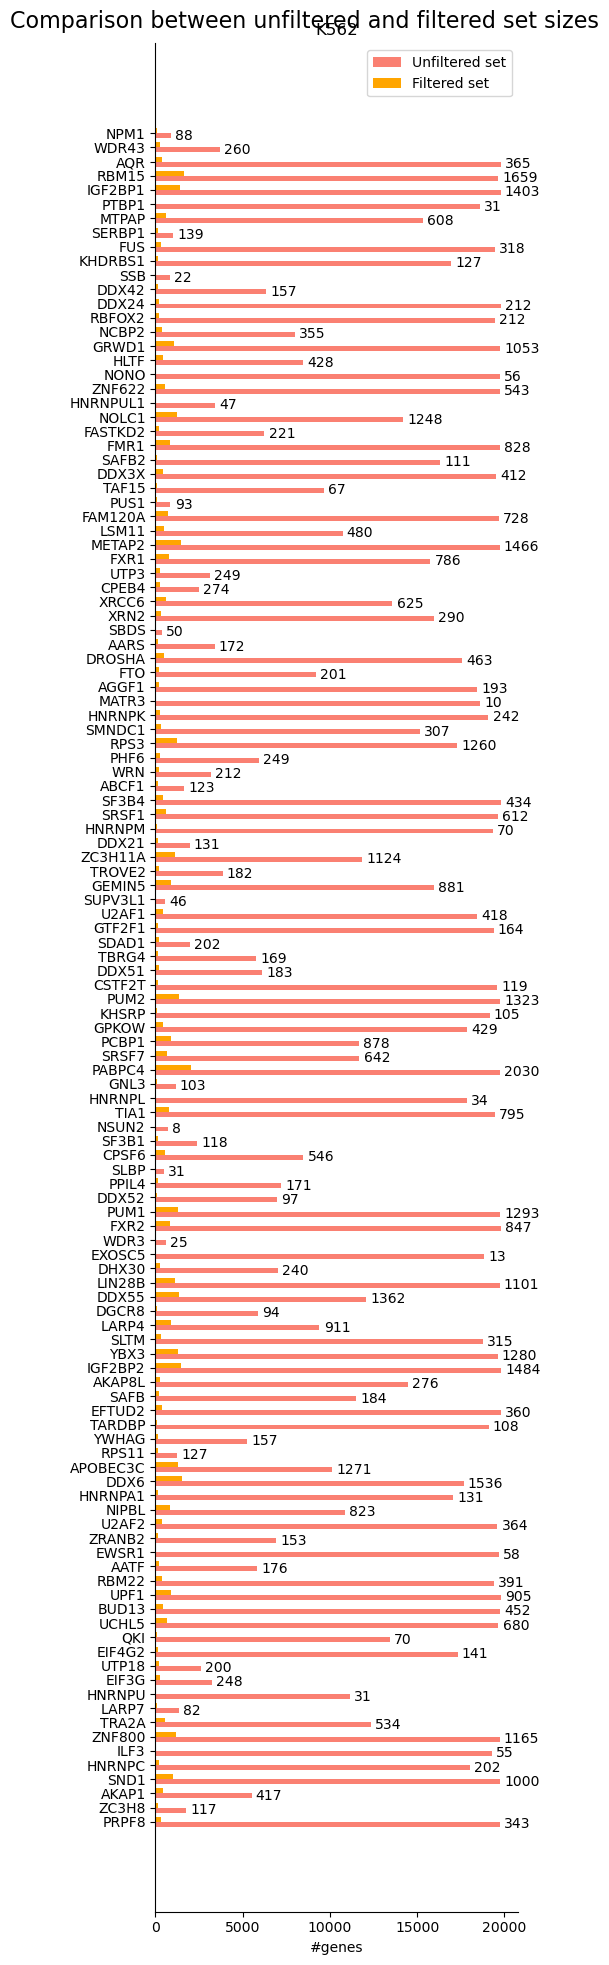

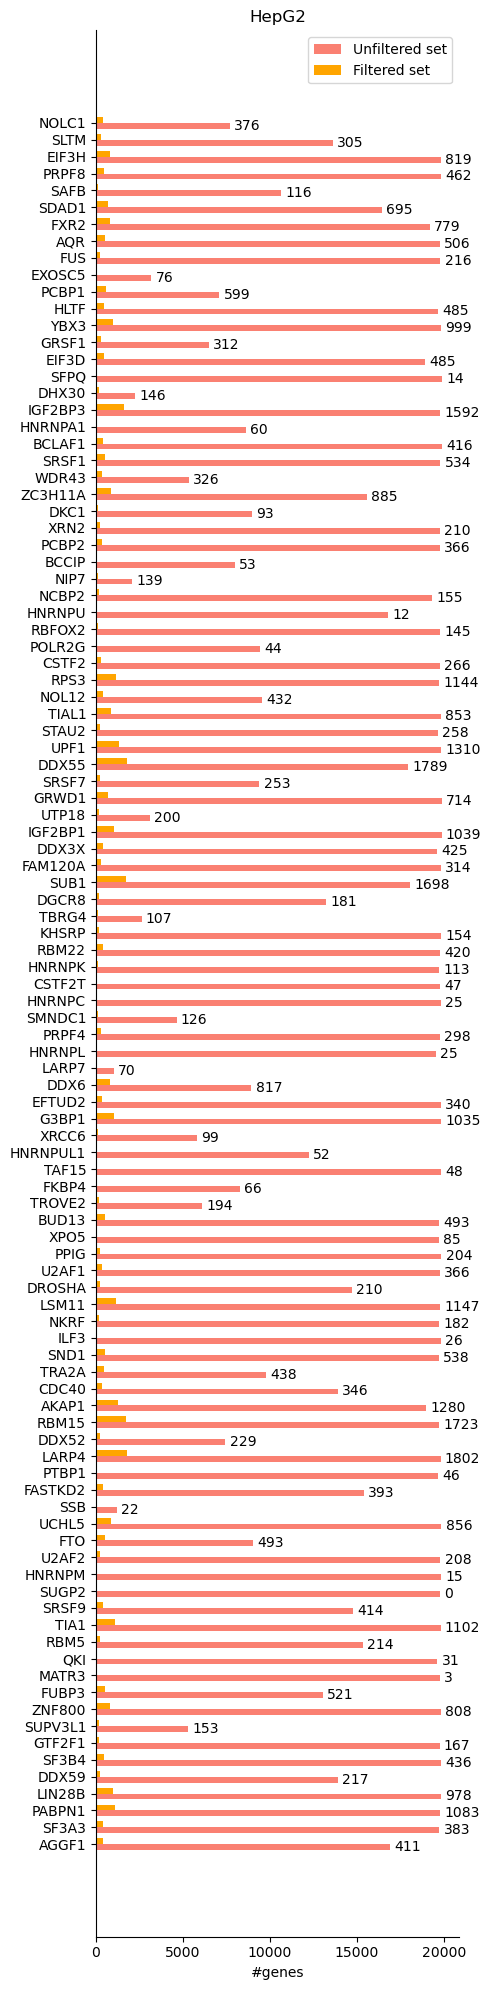

In [79]:
#preparing the plots with the comparison between filtered and unfiltered datasets 
import matplotlib.pyplot as plt
import numpy as np
#from brokenaxes import brokenaxes
 
plot_ds['percentage'] = ((plot_ds['modified length']/plot_ds['original length'] )* 100 )
plot_ds['percentage'] = plot_ds['percentage'].map(lambda x : float("{:.2f}".format(x)))
#plot_ds['percentage'] = plot_ds['percentage'].map(lambda x : str(x) + '%') 

plot_ds_Hep = plot_ds[plot_ds.RBP.map(lambda x : "HepG2" in x)]
plot_ds_K562 = plot_ds[plot_ds.RBP.map(lambda x : "K562" in x)]

#K562
labelsK = plot_ds_K562['RBP'].str.split('_').str[0]#removed the cell line because I'm going to do two plots
bar1K = plot_ds_K562['original length']
bar2K = plot_ds_K562['modified length']
percentageK = plot_ds_K562['percentage']

xK = np.arange(len(labelsK))  # the label locations
width = 0.35  # the width of the bars

#fig, (ax, axK)  = plt.subplots(1,2)
figK, axK = plt.subplots(figsize=(5, 20))
rects1K = axK.barh(xK - width/2, bar1K, width, color='#FA8072', label='Unfiltered set')
rects2K = axK.barh(xK + width/2, bar2K, width, color='#FFA500', label='Filtered set')

# Add some text for labels, title and custom x-axis tick labels, etc.
axK.set_xlabel('#genes')
axK.set_title('K562') #here introduce a new plot in the same figure to divide cell lines
axK.set_yticks(xK, labelsK)
axK.legend()

axK.bar_label(rects1K, labels = bar2K, padding=3)
#axK.bar_label(rects2K, labels = None, padding=3)

axK.spines[['top', 'right']].set_visible(False)

#Hep
labels = plot_ds_Hep['RBP'].str.split('_').str[0]#removed the cell line because I'm going to do two plots
bar1 = plot_ds_Hep['original length']
bar2 = plot_ds_Hep['modified length']
percentage = plot_ds_Hep['percentage']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(5, 20))
rects1 = ax.barh(x - width/2, bar1, width, color='#FA8072', label='Unfiltered set')
rects2 = ax.barh(x + width/2, bar2, width, color='#FFA500', label='Filtered set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('#genes')
ax.set_title('HepG2') #here introduce a new plot in the same figure to divide cell lines
ax.set_yticks(x, labels)
ax.legend()

ax.bar_label(rects1,labels = bar2, padding=3)
#ax.bar_label(rects2, labels = None ,padding=3)

ax.spines[['top', 'right']].set_visible(False)

figK.suptitle('Comparison between unfiltered and filtered set sizes', fontsize=16)

fig.tight_layout()

figK.tight_layout()

plt.show()

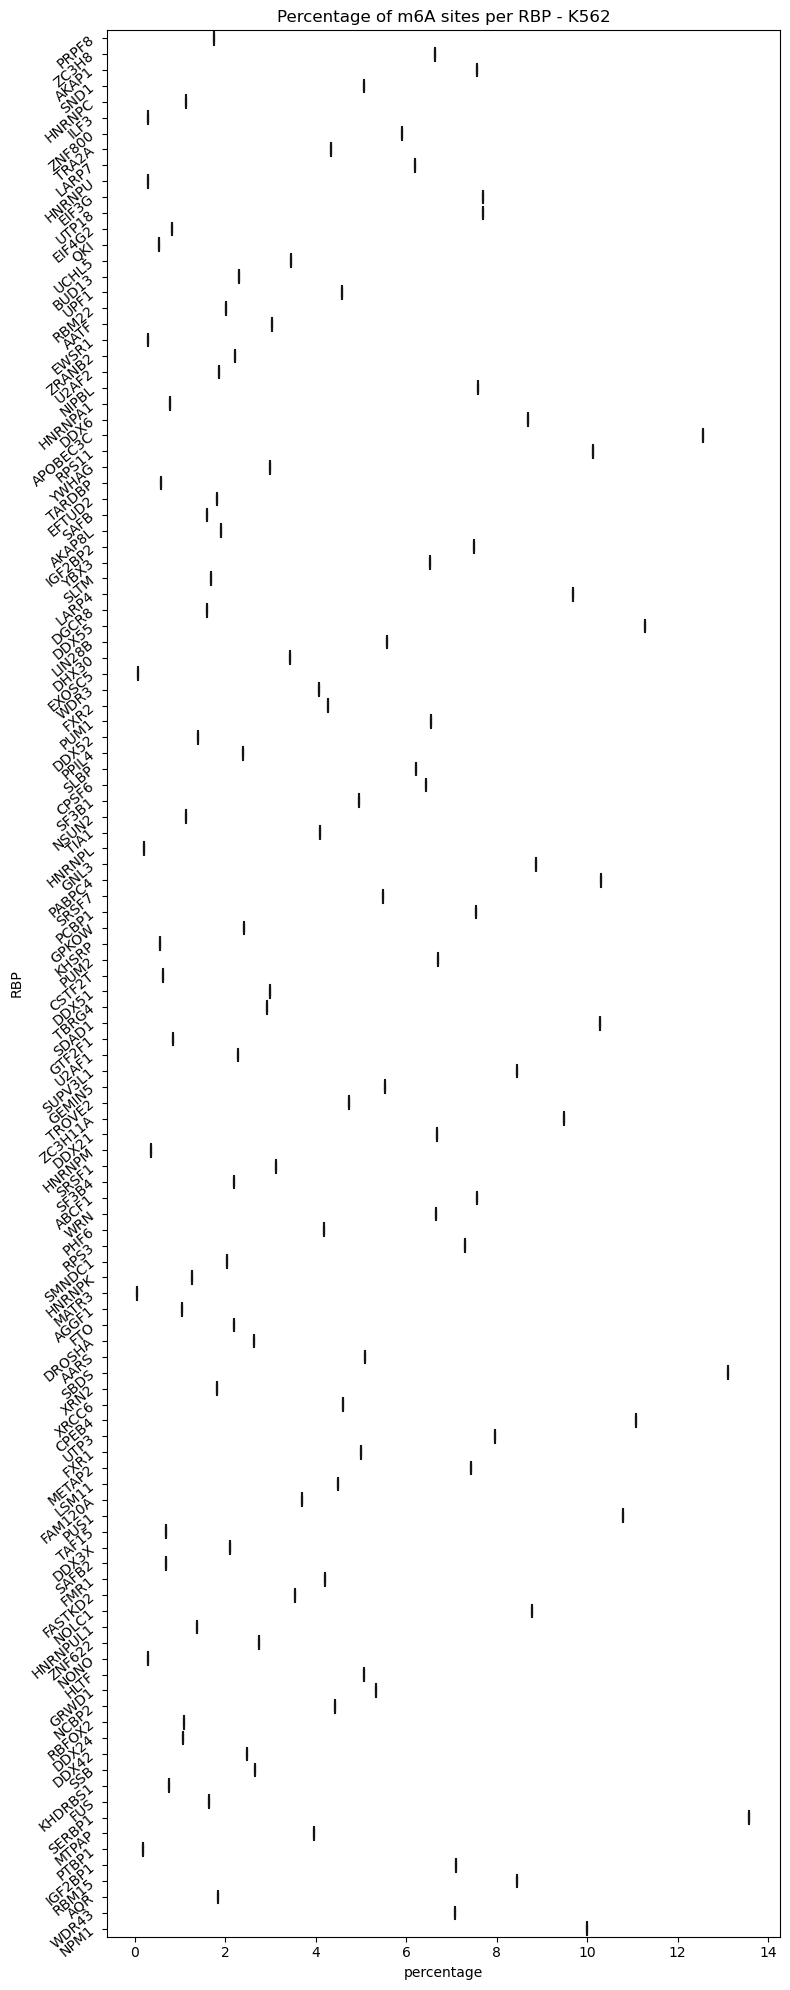

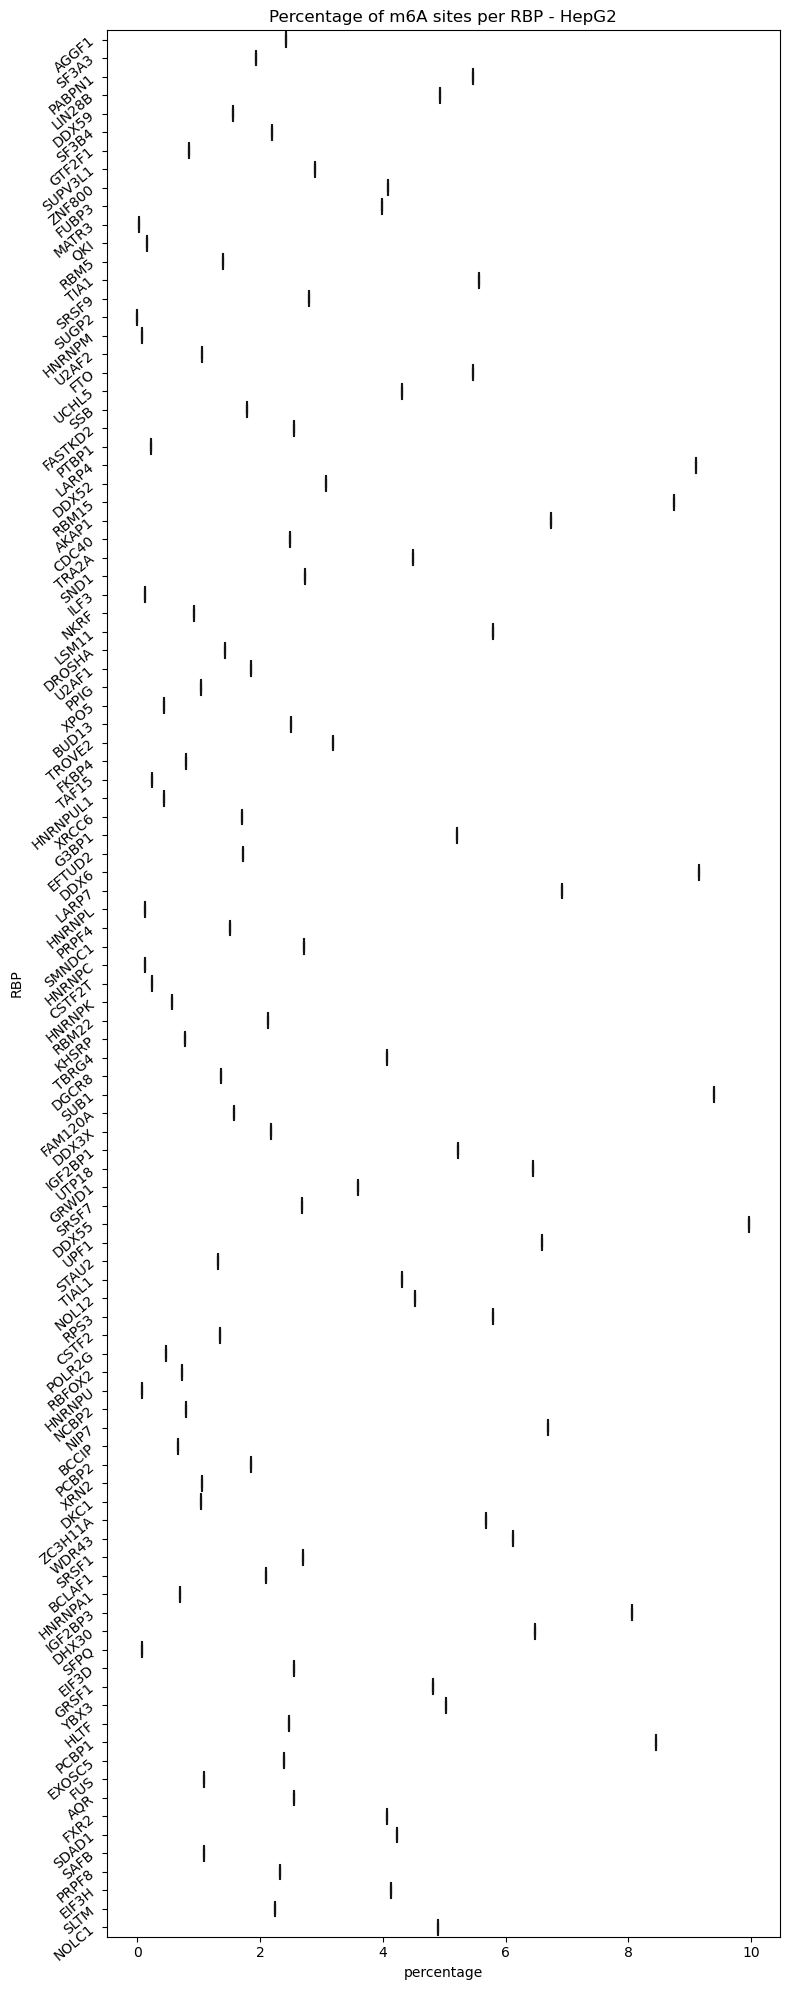

In [87]:
import seaborn as sns
#would be nice to colour the different sets of occurrences 

#my_pal = {percentage: "r" if percentage < 2 if "b" percentage < 8 else "y" percentage > 8 }
#my_pal = {percentage < 2: "g", 2<percentage<8: "b", percentage>8:"m"}
my_pal = 'Greens'

plt.figure(figsize=(8,20))
ax = sns.boxplot(data=plot_ds_K562, x="percentage", y=labelsK, palette = my_pal)
ax.set_yticklabels(ax.get_yticklabels(), rotation=40, ha="right")
plt.title('Percentage of m6A sites per RBP - K562')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,20))
ax = sns.boxplot(data=plot_ds_Hep, x="percentage", y=labels, palette = my_pal)
ax.set_yticklabels(ax.get_yticklabels(), rotation=40, ha="right")
plt.title('Percentage of m6A sites per RBP - HepG2')
plt.tight_layout()
plt.show()

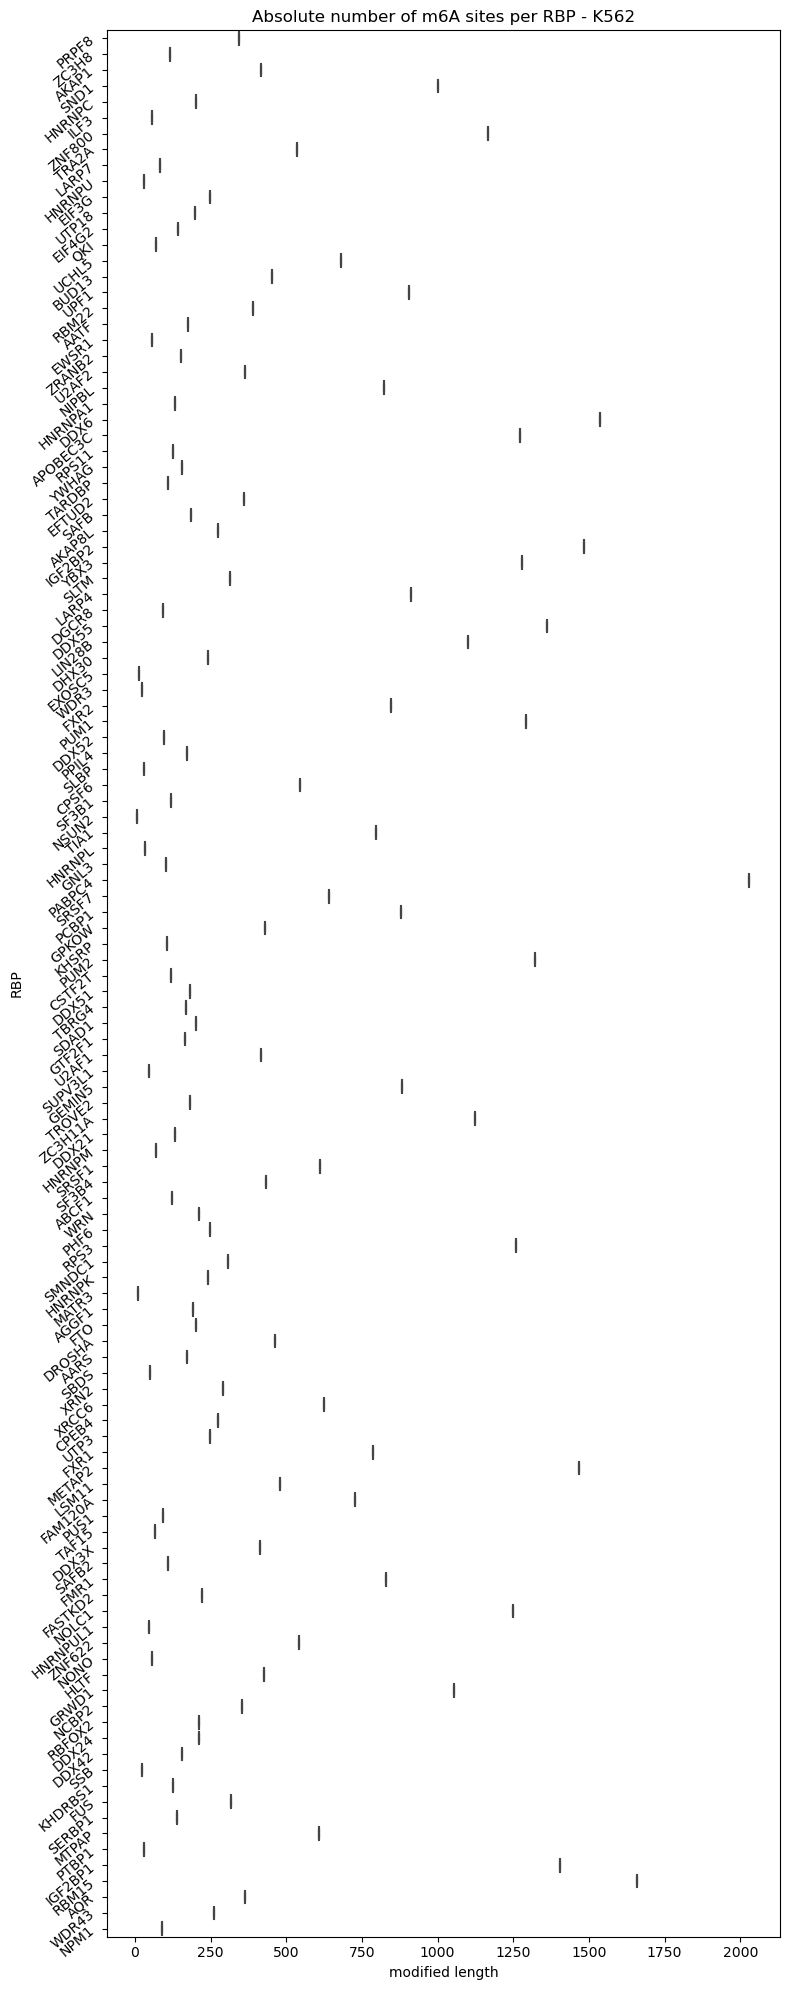

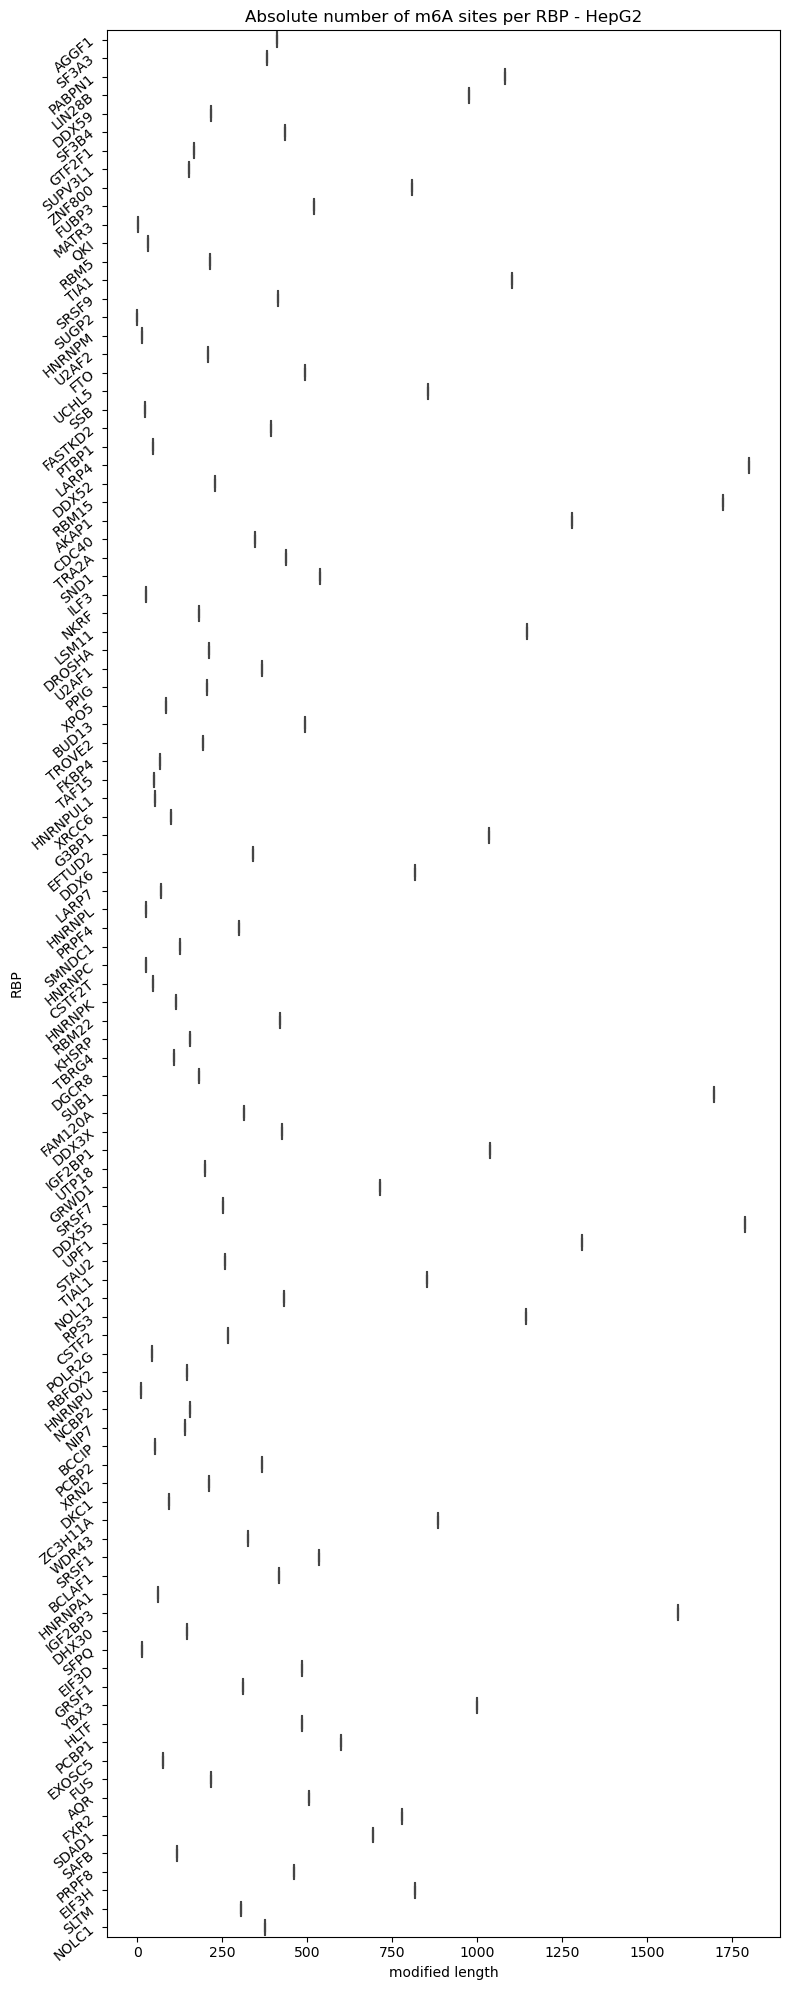

In [81]:
import seaborn as sns

plt.figure(figsize=(8,20))
ax = sns.boxplot(data=plot_ds_K562, x="modified length", y=labelsK)
ax.set_yticklabels(ax.get_yticklabels(), rotation=40, ha="right")
plt.title('Absolute number of m6A sites per RBP - K562')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,20))
ax = sns.boxplot(data=plot_ds_Hep, x='modified length', y=labels)
ax.set_yticklabels(ax.get_yticklabels(), rotation=40, ha="right")
plt.title('Absolute number of m6A sites per RBP - HepG2')
plt.tight_layout()
plt.show()